In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

scaler = MinMaxScaler()

### Number of advisors per hour

In [2]:
gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'
df = pd.read_excel('Planning intra-day 2020-01-01 au 2020-04-30.xlsx')
df = df.fillna(0.0)
df.head()

,Stauts,Date nominale,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,Logged in,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,2,1,1,1,1,1,1,1,1,1
1,Logged in,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,6,4,4,3,2,2,1,1,1,1
2,Logged in,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,9,7,5,3,3,2,2,1,2,2
3,Logged in,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,3,2,2,2,1,1,1,1,1
4,Logged in,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,2,2,2,2,1,1,1,1,1


In [4]:
# Most calls happen in this period
cols = ['08:00', '09:00', '10:00', '11:00', '12:00',
        '13:00', '14:00', '15:00', '16:00', '17:00']
df['date'] = pd.to_datetime(df['Date nominale'])
df['avg_num_adv'] = df[cols].mean(axis=1)
advisor_df = df[['date', 'avg_num_adv']]

### Daily Performance

In [7]:
perf = pd.read_csv(dataset_path + 'performance_centre_appels_sept2017_mars2020.csv', encoding='iso-8859-1')
perf.columns = ['week_day', 'date', 'total_calls', 'accept', 'accept_percent', 'abandon', 'abandon_percent',
                'SLA', 'avg_time_treat', 'avg_time_engage', 'avg_time_accept', 'avg_time_abadon', 
                'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend', 'abandon_during_ring',
                'abandon_short', 'other']
perf.head()

,week_day,date,total_calls,accept,accept_percent,abandon,abandon_percent,SLA,avg_time_treat,avg_time_engage,avg_time_accept,avg_time_abadon,max_time_accept,max_time_abandon,accept_percent_no_attend,abandon_during_ring,abandon_short,other
0,Vendredi,2017-09-01,448,410,0.915179,38,0.084821,0.658482,487.897561,436.109756,124.582927,137.973684,962,849,0.243902,0,1,0
1,Samedi,2017-09-02,142,133,0.936620,9,0.063380,0.802817,364.285714,333.285714,78.804511,161.111111,1441,369,0.721805,0,0,0
2,Dimanche,2017-09-03,113,106,0.938053,7,0.061947,0.867257,279.584906,259.566038,51.481132,114.714286,402,354,0.471698,0,2,0
3,Lundi,2017-09-04,205,186,0.907317,19,0.092683,0.863415,407.005376,382.005376,27.666667,231.944444,449,1021,0.774194,1,2,0
4,Mardi,2017-09-05,787,698,0.886912,89,0.113088,0.592122,417.938395,381.512894,146.882521,148.918605,683,681,0.163324,3,4,1


### Average daily abandon percentage

#### KPI: % Drop goal 10%: Percentage Total of abandoned calls per day. The objective is to reach an average daily percentage of abandoned calls less than or equal to 10% of all calls Receipts



- Current average daily percentage of abandoned calls is 20% for year 2020
- Given correlation between abandon percentage and average wait time, reducing average wait time will decrease abandon percentage

### Correlation between average waiting time and abandon percentage

Abandon percentage: 19.99%
Corr coef: 0.8186, p-value: 3.79e-23


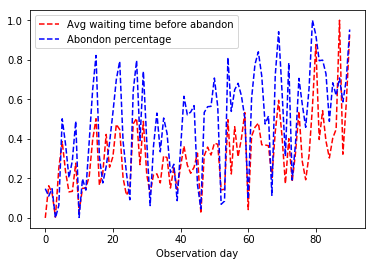

In [20]:
perf['avg_time_accept_min'] = perf['avg_time_accept'] / 60.
perf['avg_time_abandon_min'] = perf['avg_time_abadon'] / 60.
perf['abandon_percentage'] = perf['abandon_percent'] * 100.
test = perf[perf['date'] >= '2020-01-01']

#
mean_abandon = 100*test['abandon_percent'].mean()
print('Abandon percentage: %.2f%%' % mean_abandon)

# Do a pearson correlation analysis
pearson_r , p_val = stats.pearsonr(test['avg_time_abandon_min'], test['abandon_percentage'])
print('Corr coef: %.4f, p-value: %.2e' % (pearson_r , p_val))

x  = range(test.shape[0])

# Scale the data
scaler.fit(test[['avg_time_abandon_min', 'abandon_percentage']])
y = scaler.transform(test[['avg_time_abandon_min', 'abandon_percentage']])
y1 = y[:, 0]
y2 = y[:, 1]


plt.plot(x, y1, 'r--', label='Avg waiting time before abandon') 
plt.plot(x, y2, 'b--', label='Abondon percentage')
plt.xlabel('Observation day')
plt.legend()
plt.show()

In [21]:
# Abandon percentage when average wait time < 7 mins
WAITING_TIME_GOAL = 7

avg_abandon_percent_desired = test[test['avg_time_abandon_min'] <= WAITING_TIME_GOAL][['abandon_percentage']].mean()
avg_abandon_percent_desired

abandon_percentage    10.607985
dtype: float64

### Daily wait time

#### KPI: Waiting time of 550h 300h Weekly goal: On average currently waiting the weekly rate is 550h. We want to reduce this waiting time to an average of 300 hours per week (Monday to Sunday week?)

- Dependent on volume of calls
- Based on calculations below, optimum average wait time is **7 minutes** to keep average waiting weekly rate to be 300 +- 13 in 2020

- **time to lose**: means we could've let the clients wait more time to reduce call center capacity
- **time to gain**: means we should answer quicker -> increase capacity


#### Assumption: We assume that if given the perfectly accurate prediction of number of calls, the call center management will be able to allocate exact number of advisors to keep desire average wait time

In [10]:
test

,week_day,date,total_calls,accept,accept_percent,abandon,abandon_percent,SLA,avg_time_treat,avg_time_engage,...,avg_time_abadon,max_time_accept,max_time_abandon,accept_percent_no_attend,abandon_during_ring,abandon_short,other,avg_time_accept_min,avg_time_abandon_min,abandon_percentage
853,Jeudi,2020-01-02,285,268,0.940351,17,0.059649,0.603509,366.619403,310.440298,...,296.176471,1526,1016,0.511194,0,1,0,3.905286,4.936275,5.964912
854,Vendredi,2020-01-03,297,275,0.925926,22,0.074074,0.663300,458.356364,412.469091,...,238.681818,1417,1029,0.545455,0,1,0,3.881394,3.978030,7.407407
855,Samedi,2020-01-04,115,113,0.982609,2,0.017391,0.808696,363.079646,321.415929,...,37.000000,1216,68,0.690265,0,1,1,1.876401,0.616667,1.739130
856,Dimanche,2020-01-05,96,92,0.958333,4,0.041667,0.718750,436.108696,381.576087,...,442.250000,1357,1236,0.565217,0,0,0,2.134420,7.370833,4.166667
857,Lundi,2020-01-06,754,596,0.790451,158,0.209549,0.210875,634.010067,531.823825,...,661.626582,3309,2801,0.095638,0,6,0,15.616834,11.027110,20.954907
858,Mardi,2020-01-07,570,479,0.840351,91,0.159649,0.264912,644.684760,545.427975,...,410.911111,2145,1699,0.146138,1,2,1,10.151044,6.848519,15.964912
859,Mercredi,2020-01-08,535,484,0.904673,51,0.095327,0.543925,576.347107,496.095041,...,245.265306,1401,620,0.283058,2,3,0,3.933230,4.087755,9.532710
860,Jeudi,2020-01-09,483,421,0.871636,62,0.128364,0.362319,633.988124,547.952494,...,249.806452,1546,1343,0.173397,0,3,3,5.644616,4.163441,12.836439
861,Vendredi,2020-01-10,473,376,0.794926,97,0.205074,0.243129,675.819149,572.779255,...,482.618557,2390,2134,0.130319,0,3,3,12.581738,8.043643,20.507400
862,Samedi,2020-01-11,109,107,0.981651,2,0.018349,0.779817,457.700935,401.728972,...,83.000000,3992,118,0.616822,0,0,0,2.557632,1.383333,1.834862


In [11]:
test['accept_time_gains']  = (test['avg_time_accept_min']  - WAITING_TIME_GOAL) * test['accept']  / 60
test['abandon_time_gains'] = (test['avg_time_abandon_min'] - WAITING_TIME_GOAL) * test['abandon'] / 60

print("accept time to lose", test.loc[test['accept_time_gains'] < 0, 'accept_time_gains'].sum(), 'hours')
print("accept time to gain", test.loc[test['accept_time_gains'] > 0, 'accept_time_gains'].sum(), 'hours')
#
print("abandon time to lose", test.loc[test['abandon_time_gains'] < 0, 'abandon_time_gains'].sum(), 'hours')
print("abandon time to gain", test.loc[test['abandon_time_gains'] > 0, 'abandon_time_gains'].sum(), 'hours')

accept time to lose -241.34361110599167 hours
accept time to gain 3953.3122224082776 hours
abandon time to lose -28.740208718247224 hours
abandon time to gain 675.8711524366945 hours


/Users/daidao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/daidao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Weekly wait time

In [12]:
perf['total_time_accept']  = (perf['avg_time_accept'] * perf['accept']) / (60 * 60)
perf['total_time_abandon'] = (perf['avg_time_abadon'] * perf['abandon']) /  (60 * 60)
perf['total_time_desire']  = perf['total_calls'] * WAITING_TIME_GOAL / 60
#
perf['date'] = pd.to_datetime(perf['date'])

In [13]:
out = perf[['date', 'total_time_accept', 'total_time_abandon', 'total_time_desire']]
out = perf.resample('W-Mon', on='date')\
          .agg({'total_time_accept' : np.sum, 
                'total_time_abandon' : np.sum,
                'total_time_desire' : np.sum}).reset_index()\
          .sort_values(by='date')
#
print(out[out['date'] > '2020-01-01']['total_time_desire'].mean())
out[out['date'] > '2020-01-01']

312.7416666666667


,date,total_time_accept,total_time_abandon,total_time_desire
122,2020-01-06,211.780278,34.483639,202.183333
123,2020-01-13,269.571667,35.200678,334.016667
124,2020-01-20,553.461111,109.644346,361.200000
125,2020-01-27,636.373333,140.391343,361.083333
126,2020-02-03,587.651667,127.817778,374.033333
127,2020-02-10,350.370556,54.363126,320.833333
128,2020-02-17,476.483056,87.031916,337.283333
129,2020-02-24,543.780556,133.907082,333.666667
130,2020-03-02,525.653889,120.237563,329.700000
131,2020-03-09,591.743056,154.143950,313.833333


### Join with number of advisors

- Can get the number of calls per hour to join with number of advisors per hour for next step


### Temporary Conclusion

- if ratio between average number of call volume per hour and average number of advisors per hours is < 5, then average wait time should be within 7 minutes desired wait time

In [14]:
test = test[['date', 'total_calls', 'accept_percent', 'abandon_percent', 'avg_time_accept_min', 'avg_time_abandon_min']]
test['date'] = pd.to_datetime(test['date'])
test = test.merge(advisor_df, on='date', how='inner')
test['ratio_call_advisor'] = (test['total_calls'] / 10) / test['avg_num_adv']
#
test[(test['avg_time_accept_min'] < WAITING_TIME_GOAL) & (test['avg_time_abandon_min'] < WAITING_TIME_GOAL)]['ratio_call_advisor'].mean()

/Users/daidao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4.899383962739378

In [15]:
test[(test['avg_time_accept_min'] > WAITING_TIME_GOAL) & (test['avg_time_abandon_min'] > WAITING_TIME_GOAL)]['ratio_call_advisor'].mean()

6.707333635734546

### ROI with Prediction

In [3]:
def cast_CCT_features(df):
    dates_list = ['Submit_Date','Reported_Date','Required_Resolution_DateTime','Responded_Date','Last_Resolved_Date','closed_date']
    for col in dates_list:
        df[col] = pd.to_datetime(df[col].fillna('1900-01-01 00:00:00.000'))
        df[col + '_day'] = df[col].apply(lambda x: x.strftime('%Y-%m-%d')) # To group by day
        df[col + '_with_hour'] =df[col].apply(lambda x: x.strftime('%Y-%m-%d %H:00')) # To group by day
    return df

In [4]:
result_path = gs_uri + 'results/'

preds = pd.read_csv(result_path + "results_ticket_count_prediction_202005062015.csv")
preds['date'] = pd.to_datetime(preds['date'])
#
perf = pd.read_csv(dataset_path + 'performance_centre_appels_sept2017_mars2020.csv', encoding='iso-8859-1')
perf.columns = ['week_day', 'date', 'total_calls', 'accept', 'accept_percent', 'abandon', 'abandon_percent',
                'SLA', 'avg_time_treat', 'avg_time_engage', 'avg_time_accept', 'avg_time_abadon', 
                'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend', 'abandon_during_ring',
                'abandon_short', 'other']
perf['date'] = pd.to_datetime(perf['date'])
perf = perf[['date', 'total_calls', 'avg_time_accept', 'avg_time_abadon']]
#
inci = pd.read_csv(dataset_path + 'IncidentsCTT20170930_2.csv', encoding="ISO-8859-1", low_memory=False)
inci = inci.loc[~inci['Submitter'].str.contains('SYSTEM')]
inci = cast_CCT_features(inci)
groupby = inci.groupby('Submit_Date_day')
agg_df = pd.DataFrame(groupby['status'].count().reset_index().values, columns=['Submit_Date_day', 'Ticket cnt'])
agg_df['total_real_calls'] = agg_df['Ticket cnt'].astype(int)
agg_df['date'] = pd.to_datetime(agg_df['Submit_Date_day'])
agg_df = agg_df[['date', 'total_real_calls']]

In [7]:
final = preds[['date', 'ticket cnt pred']]\
                .merge(perf[['date', 'total_calls', 'avg_time_accept', 'avg_time_abadon']], 
                       on='date', how='left')\
                .merge(agg_df, on='date', how='left')
final.head()

,date,ticket cnt pred,total_calls,avg_time_accept,avg_time_abadon,total_real_calls
0,2020-01-01,102.35755,27.0,79.440000,30.000000,10
1,2020-01-02,190.30754,285.0,234.317164,296.176471,221
2,2020-01-03,186.17322,297.0,232.883636,238.681818,210
3,2020-01-04,125.01209,115.0,112.584071,37.000000,90
4,2020-01-05,120.05078,96.0,128.065217,442.250000,71


### Optimal case with perfect prediction

In [14]:
final['accept_time_gains']  = (final['avg_time_accept']/60.  - 7.) * final['total_real_calls']  / 60
#
print("accept time to lose", final.loc[final['accept_time_gains'] < 0, 'accept_time_gains'].sum(), 'hours')
print("accept time to gain", final.loc[final['accept_time_gains'] > 0, 'accept_time_gains'].sum(), 'hours')

accept time to lose -187.0101893750222 hours
accept time to gain 2918.3538171031664 hours


### With prediction

- Assume that the difference between predicted and total calls have a direct linear impact on the average wait time
- The result suggests that the prediction tend to over-predict, which benefits time to gain, and at the same time increase time to lose

In [15]:
final['avg_time_pred'] = (final['total_real_calls'] / final['ticket cnt pred']) * 7.
#
final['pred_time_gains']  = (final['avg_time_accept']/60. - final['avg_time_pred']) * final['total_real_calls'] /60.
#
print("pred time to lose", final.loc[final['pred_time_gains'] < 0, 'pred_time_gains'].sum(), 'hours')
print("pred time to gain", final.loc[final['pred_time_gains'] > 0, 'pred_time_gains'].sum(), 'hours')

pred time to lose -199.08931445531346 hours
pred time to gain 2930.2202666053067 hours


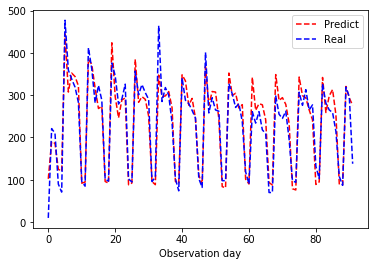

In [17]:
plt.plot(range(final.shape[0]), final['ticket cnt pred'], 'r--', label='Predict') 
plt.plot(range(final.shape[0]), final['total_real_calls'], 'b--', label='Real')
plt.xlabel('Observation day')
plt.legend()
plt.show()